In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import os
from keras.utils import np_utils
from dev.preprocessing import faceMesh_video
from dev.preprocessing import handPose_video
from dev.preprocessing import points_to_displacement



In [2]:
# 오래걸림!!! 주의하셈 1분 넘게 걸린다.
# Long time to run!! Caution.
with open('../dataset/processed/KSL_handpose_and_facemesh.p', 'rb') as handle:
    dataset = pickle.load(handle)

In [3]:
print(len(dataset))

1100


In [4]:
for i in range(1100):
    index = dataset[i][1]-1
    vector = [0 for _ in range(77)]
    vector[index] = 1
    dataset[i][1] = vector


In [5]:
# print(dataset[0])
print(len(dataset))
TRAIN_SPLIT = 880
# 0.8 * 1100 = 1232 개

1100


In [6]:
print(len(dataset[0][0][0])) # 128 + 21 * 2

170


In [7]:

random.shuffle(dataset)
train_data = dataset[:900]
test_data = dataset[900:]

x_train = []
x_test = []
y_train = []
y_test = []

for i in range(len(train_data)):
    x_train.append(train_data[i][0][20:30])
    y_train.append(np.array(train_data[i][1]))

for i in range(len(test_data)):
    x_test.append(test_data[i][0][20:30])
    y_test.append(np.array(test_data[i][1]))
    
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(np.array(y_test))

In [8]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(900, 10, 170, 3) (900, 77) (200, 10, 170, 3) (200, 77)


In [9]:
x_test

array([[[[ 2.17634439e-03,  3.40074301e-04,  1.07204448e-03],
         [ 2.04032660e-03,  2.41518021e-04, -2.45834514e-03],
         [ 3.36593390e-03,  1.21071935e-03, -2.83020461e-03],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 1.23441219e-03,  1.31100416e-04, -3.77774239e-04],
         [ 1.41465664e-03,  1.35010481e-03,  1.74249057e-04],
         [ 1.05100870e-03, -5.23388386e-04,  1.48450740e-03],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 1.97720528e-03, -1.42753124e-04,  3.45936976e-04],
         [ 1.33132935e-03,  4.35829163e-04, -1.45652238e-03],
         [ 2.36010551e-03, -1.78346038e-03, -1.53447592e-03],
         ...,
         [ 0.00000000e+0

In [10]:
shape_points = (100, 170, 3)
x_train = x_train.reshape(x_train.shape[0], 10, 170*3)
x_test = x_test.reshape(x_test.shape[0], 10, 170*3)

# model = keras.models.Sequential()

# model.add(keras.layers.LSTM(100, input_shape=(100, 510)))
# model.add(keras.layers.Dense(100, activation='relu'))
# model.add(keras.layers.Dense(70, activation='relu'))
# model.add(keras.layers.Dense(77, activation='softmax'))

# model = keras.models.Sequential()

# model.add(keras.layers.GRU(256, return_sequences=True, input_shape=(100, 510)))
# model.add(keras.layers.SimpleRNN(128))
# model.add(keras.layers.Dense(128, activation='leaky_relu'))
# model.add(keras.layers.Dense(128, activation='leaky_relu'))
# model.add(keras.layers.Dense(77, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.002), metrics=['acc'])

In [15]:
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=(10, 3*170), dtype='float32', name='input_all'))
model.add(keras.layers.GRU(256, return_sequences=True, name='all_gru'))
model.add(keras.layers.SimpleRNN(32, name="all_rnn"))
model.add(keras.layers.BatchNormalization(name='batch_normal_all_1'))
model.add(keras.layers.Flatten(name='flatten_all'))
model.add(keras.layers.Dense(64, activation='leaky_relu', name='h_all_1'))
model.add(keras.layers.BatchNormalization(name='batch_normal_all_2'))
model.add(keras.layers.Dense(64, activation='leaky_relu', name='h_all_2'))
model.add(keras.layers.Dense(128, activation='leaky_relu', name='h_all_3'))
model.add(keras.layers.Dense(256, activation='leaky_relu', name='h_all_4'))
model.add(keras.layers.Dense(77, activation='softmax', name='output_all'))

In [16]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 all_gru (GRU)               (None, 10, 256)           589824    
                                                                 
 all_rnn (SimpleRNN)         (None, 32)                9248      
                                                                 
 batch_normal_all_1 (BatchNo  (None, 32)               128       
 rmalization)                                                    
                                                                 
 flatten_all (Flatten)       (None, 32)                0         
                                                                 
 h_all_1 (Dense)             (None, 64)                2112      
                                                                 
 batch_normal_all_2 (BatchNo  (None, 64)               256       
 rmalization)                                         

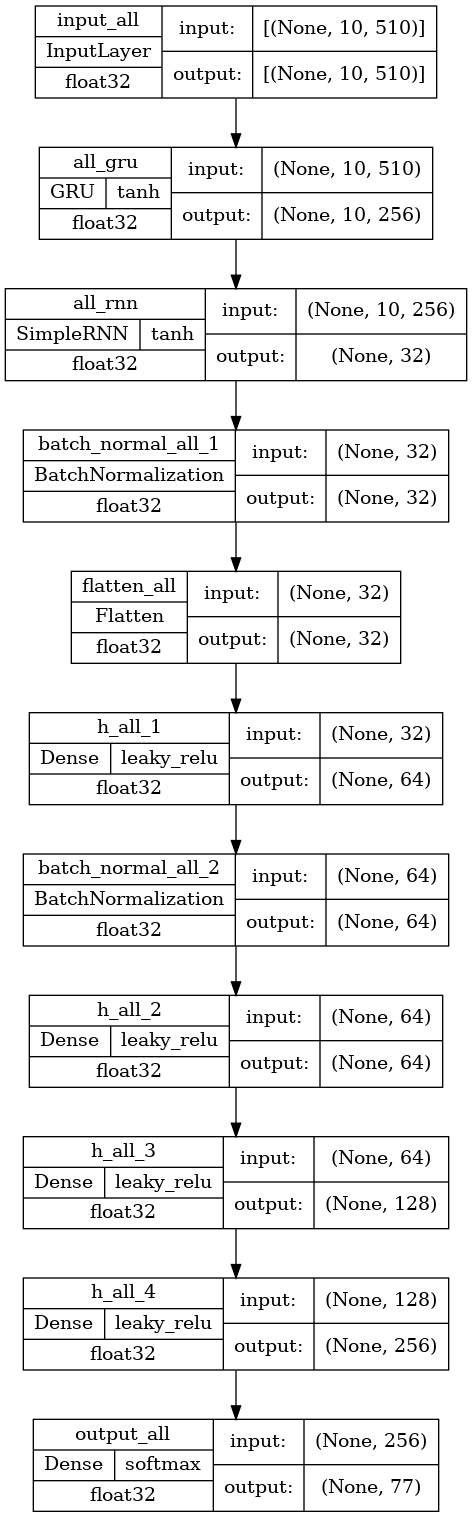

In [18]:
keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, show_layer_activations=True)

In [96]:
 
history = model.fit(x_train, y_train, epochs=100, batch_size=256, validation_data=(x_test, y_test))


Epoch 1/100
4/4 [==============================] - 2s 109ms/step - loss: 4.3712 - accuracy: 0.0167 - val_loss: 4.3416 - val_accuracy: 0.0100
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 4.2313 - accuracy: 0.0422 - val_loss: 4.3403 - val_accuracy: 0.0100
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 4.1368 - accuracy: 0.0533 - val_loss: 4.3392 - val_accuracy: 0.0100
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 4.0521 - accuracy: 0.0589 - val_loss: 4.3368 - val_accuracy: 0.0100
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 3.9760 - accuracy: 0.0711 - val_loss: 4.3336 - val_accuracy: 0.0100
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 3.8830 - accuracy: 0.0867 - val_loss: 4.3287 - val_accuracy: 0.0050
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 3.7975 - accuracy: 0.1156 - val_loss: 4.3237 - val_accuracy: 0.0150
Epoch 8/100
4/4 [==

4/4 [==============================] - 0s 11ms/step - loss: 0.7270 - accuracy: 0.8478 - val_loss: 5.6954 - val_accuracy: 0.0050
Epoch 60/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7746 - accuracy: 0.8333 - val_loss: 5.6633 - val_accuracy: 0.0050
Epoch 61/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7158 - accuracy: 0.8400 - val_loss: 5.9832 - val_accuracy: 0.0050
Epoch 62/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7123 - accuracy: 0.8367 - val_loss: 6.3629 - val_accuracy: 0.0100
Epoch 63/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7204 - accuracy: 0.8444 - val_loss: 6.2245 - val_accuracy: 0.0100
Epoch 64/100
4/4 [==============================] - 0s 11ms/step - loss: 0.6277 - accuracy: 0.8567 - val_loss: 6.5351 - val_accuracy: 0.0100
Epoch 65/100
4/4 [==============================] - 0s 11ms/step - loss: 0.6073 - accuracy: 0.8622 - val_loss: 6.5455 - val_accuracy: 0.0100
Epoch 66/100
4/4 [========